In [1]:
!pip install ../input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591/

Processing /kaggle/input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591
  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=17598 sha256=ee1fb57a969f025ba2cf290682c4bbb77e7c39ea4e86e601e965c13925692139
  Stored in directory: /tmp/.cache/pip/wheels/71/5b/7b/ad46760ebf29c8a85233044e3caba4cf19d7e12f1ab41a3862
Successfully built efficientnet


### Dependencies

In [2]:
# Link for the script https://www.kaggle.com/dimitreoliveira/cloud-images-segmentation-utillity-script
from cloud_images_segmentation_utillity_script import *
import efficientnet.keras as efn

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


### Load data

In [3]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])
test['set'] = 'test'

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105
Test samples: 14792


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,66cda54.jpg,NaN,NaN,NaN,18208 624 19608 624 21008 624 22408 624 23808 ...,0,0,0,1,train
1,61d6640.jpg,NaN,NaN,1349079 387 1350479 387 1351879 387 1353279 38...,373839 334 375239 334 376639 334 378039 334 37...,0,0,1,1,train
2,bb31239.jpg,29 604 1429 604 2829 604 4229 604 5629 604 702...,1692065 510 1693465 510 1694865 510 1696265 51...,NaN,NaN,1,1,0,0,train
3,74d06fc.jpg,NaN,NaN,1435419 454 1436819 454 1438219 454 1439619 45...,NaN,0,0,1,0,train
4,f13cbe0.jpg,330457 1020 331857 1020 333257 1020 334657 102...,390661 1208 392061 1208 393461 1208 394861 120...,1629705 16 1629722 1144 1631105 16 1631122 4 1...,2561203 314 2562603 314 2564003 314 2565403 31...,1,1,1,1,train


# Model parameters

In [4]:
BACKBONE = 'EfficientNetB4'
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 3e-4
HEIGHT = 256
WIDTH = 384
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

model_name = 'uNet_%s_%sx%s' % (BACKBONE, HEIGHT, WIDTH)
model_path = '../working/%s' % (model_name)

train_images_path = '../input/cloud-images-resized-256x384/train_images256x384/train_images/'
test_images_path = '../input/cloud-images-resized-256x384/test_images256x384/test_images256x384/'

In [5]:
# preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.GridDistortion(p=0.5),
                             albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=45, 
                                                   shift_limit=0.1, border_mode=0, p=0.5),
                             albu.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
                             albu.Rotate(limit=45, p=0.5)
                            ])

### Data generator

In [6]:
train_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
#                   preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
#                   preprocessing=preprocessing,
                  seed=seed)

# Model

In [7]:
from keras.layers import BatchNormalization, LeakyReLU
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.merge import concatenate, Concatenate
from keras.layers.convolutional import Conv2D
from keras.models import Model

def H(lst, name, use_gn=False):
    if use_gn:
        norm = GroupNormalization(groups=1, name=name+'_gn')
    else:
        norm = BatchNormalization(name=name+'_bn')
    
    x = concatenate(lst)
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2D(num_filters, (2, 2), padding='same', name=name)(x)
    x = norm(x)
    x = LeakyReLU(alpha=0.1, name=name+'_activation')(x)
    
    return x

def U(x, use_gn=False):
    if use_gn:
        norm = GroupNormalization(groups=1)
    else:
        norm = BatchNormalization()
    
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(x)
    x = norm(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    return x

def EfficientUNet(input_shape, weights_path):
    backbone = efn.EfficientNetB4(
                weights=None,
                include_top=False,
                input_shape=input_shape
    )
    
    backbone.load_weights(weights_path)
    
    # Skipping block 4f and block 6h since they have the same output dim as 5f and 7b
    x00 = backbone.input  # (256, 512, 3)
    x10 = backbone.get_layer('stem_activation').output  # (128, 256, 4)
    x20 = backbone.get_layer('block2d_add').output  # (64, 128, 32)
    x30 = backbone.get_layer('block3d_add').output  # (32, 64, 56)
    x40 = backbone.get_layer('block5f_add').output  # (16, 32, 160)
    x50 = backbone.get_layer('block7b_add').output  # (8, 16, 448)
    
    x01 = H([x00, U(x10)], 'X01')
    x11 = H([x10, U(x20)], 'X11')
    x21 = H([x20, U(x30)], 'X21')
    x31 = H([x30, U(x40)], 'X31')
    x41 = H([x40, U(x50)], 'X41')
    
    x02 = H([x00, x01, U(x11)], 'X02')
    x12 = H([x11, U(x21)], 'X12')
    x22 = H([x21, U(x31)], 'X22')
    x32 = H([x31, U(x41)], 'X32')
    
    x03 = H([x00, x01, x02, U(x12)], 'X03')
    x13 = H([x12, U(x22)], 'X13')
    x23 = H([x22, U(x32)], 'X23')
    
    x04 = H([x00, x01, x02, x03, U(x13)], 'X04')
    x14 = H([x13, U(x23)], 'X14')
    
    x05 = H([x00, x01, x02, x03, x04, U(x14)], 'X05')
    
    x_out = Concatenate(name='bridge')([x01, x02, x03, x04, x05])
    x_out = Conv2D(4, (3,3), padding="same", name='final_output', activation="sigmoid")(x_out)
    
    return Model(inputs=x00, outputs=x_out)

In [8]:
model = EfficientUNet((HEIGHT, WIDTH, CHANNELS), '../input/efficientnet-keras-weights-b0b5/efficientnet-b4_imagenet_1000_notop.h5')

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.2)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 384, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 192, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 192, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 192, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [9]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/20
 - 511s - loss: 1.2291 - dice_coef: 0.2809 - iou_score: 0.1131 - score: 0.1785 - val_loss: 1.1074 - val_dice_coef: 0.3783 - val_iou_score: 0.1550 - val_score: 0.2290
Epoch 2/20
 - 434s - loss: 1.0943 - dice_coef: 0.3888 - iou_score: 0.1554 - score: 0.2275 - val_loss: 1.1145 - val_dice_coef: 0.4590 - val_iou_score: 0.1794 - val_score: 0.2530
Epoch 3/20
 - 436s - loss: 1.0730 - dice_coef: 0.4150 - iou_score: 0.1655 - score: 0.2383 - val_loss: 1.0032 - val_dice_coef: 0.4691 - val_iou_score: 0.1948 - val_score: 0.2708
Epoch 4/20
 - 434s - loss: 1.0635 - dice_coef: 0.4280 - iou_score: 0.1707 - score: 0.2438 - val_loss: 1.0168 - val_dice_coef: 0.4710 - val_iou_score: 0.1861 - val_score: 0.2618
Epoch 5/20
 - 434s - loss: 1.0532 - dice_coef: 0.4393 - iou_score: 0.1751 - score: 0.2486 - val_loss: 1.0217 - val_dice_coef: 0.4881 - val_iou_score: 0.1997 - val_score: 0.2751
Epoch 6/20
 - 433s - loss: 1.0494 - dice_coef: 0.4433 - iou_score: 0.1780 - score: 0.2513 - val_loss: 1.0257 - val_

## Model loss graph

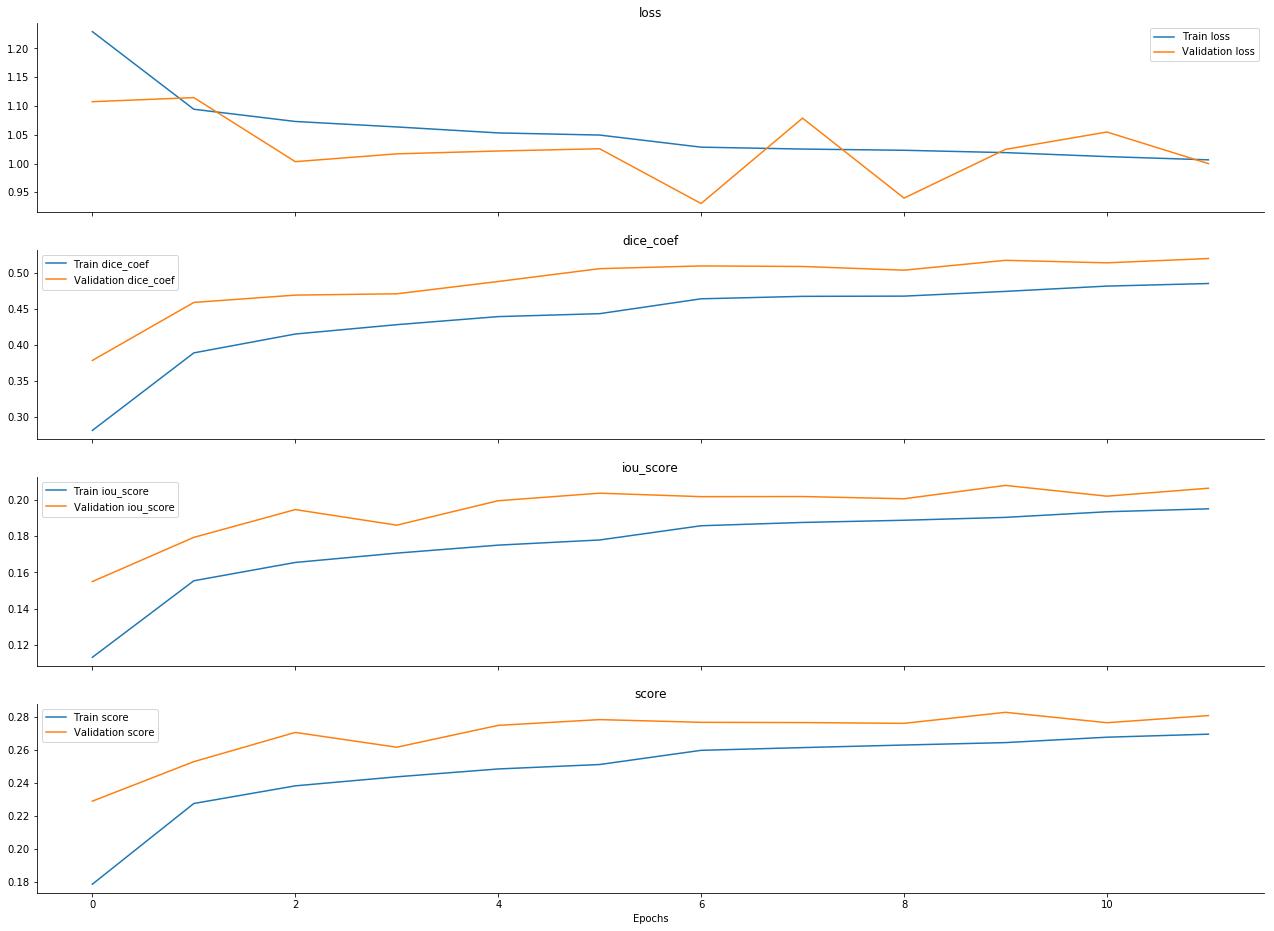

In [10]:
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'score'])

# Threshold and mask size tunning

In [11]:
class_names = ['Fish  ', 'Flower', 'Gravel', 'Sugar ']
mask_grid = [0, 500, 1000, 5000, 7500, 10000, 15000]
threshold_grid = np.arange(.5, 1, .05)
metrics = []

for class_index in range(N_CLASSES):
    for threshold in threshold_grid:
        for mask_size in mask_grid:
            metrics.append([class_index, threshold, mask_size, 0])

metrics_df = pd.DataFrame(metrics, columns=['Class', 'Threshold', 'Mask size', 'Dice'])

for i in range(0, X_val.shape[0], 500):
    batch_idx = list(range(i, min(X_val.shape[0], i + 500)))
    batch_set = X_val[batch_idx[0]: batch_idx[-1]+1]
    ratio = len(batch_set) / len(X_val)
    
    generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=batch_set,
                  target_df=train,
                  batch_size=len(batch_set), 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
#                   preprocessing=preprocessing,
                  seed=seed,
                  mode='fit',
                  shuffle=False)
    
    x, y = generator.__getitem__(0)
    preds = model.predict(x)

    for class_index in range(N_CLASSES):
        class_score = []
        label_class = y[..., class_index]
        pred_class = preds[..., class_index]
        for threshold in threshold_grid:
            for mask_size in mask_grid:
                mask_score = []
                for index in range(len(batch_idx)):
                    label_mask = label_class[index, ]
                    pred_mask = pred_class[index, ]
                    pred_mask = post_process(pred_mask, threshold=threshold, min_size=mask_size)
                    dice_score = dice_coefficient(pred_mask, label_mask)
                    if (pred_mask.sum() == 0) & (label_mask.sum() == 0):
                        dice_score = 1.
                    mask_score.append(dice_score)
                metrics_df.loc[(metrics_df['Class'] == class_index) & (metrics_df['Threshold'] == threshold) & 
                               (metrics_df['Mask size'] == mask_size), 'Dice'] += np.mean(mask_score) * ratio

metrics_df_0 = metrics_df[metrics_df['Class'] == 0]
metrics_df_1 = metrics_df[metrics_df['Class'] == 1]
metrics_df_2 = metrics_df[metrics_df['Class'] == 2]
metrics_df_3 = metrics_df[metrics_df['Class'] == 3]

optimal_values_0 = metrics_df_0.loc[metrics_df_0['Dice'].idxmax()].values
optimal_values_1 = metrics_df_1.loc[metrics_df_1['Dice'].idxmax()].values
optimal_values_2 = metrics_df_2.loc[metrics_df_2['Dice'].idxmax()].values
optimal_values_3 = metrics_df_3.loc[metrics_df_3['Dice'].idxmax()].values

best_tresholds = [optimal_values_0[1], optimal_values_1[1], optimal_values_2[1], optimal_values_3[1]]
best_masks = [optimal_values_0[2], optimal_values_1[2], optimal_values_2[2], optimal_values_3[2]]
best_dices = [optimal_values_0[3], optimal_values_1[3], optimal_values_2[3], optimal_values_3[3]]

for index, name in enumerate(class_names):
    print('%s treshold=%.2f mask size=%d Dice=%.3f' % (name, best_tresholds[index], best_masks[index], best_dices[index]))

Fish   treshold=0.50 mask size=15000 Dice=0.611
Flower treshold=0.50 mask size=10000 Dice=0.756
Gravel treshold=0.55 mask size=10000 Dice=0.605
Sugar  treshold=0.55 mask size=10000 Dice=0.596


# Model evaluation

In [12]:
train_metrics = get_metrics(model, train, X_train, train_images_path, best_tresholds, best_masks, seed=seed, preprocessing=None, set_name='Train')
display(train_metrics)

validation_metrics = get_metrics(model, train, X_val, train_images_path, best_tresholds, best_masks, seed=seed, preprocessing=None, set_name='Validation')
display(validation_metrics)

,Dice,Dice Post
Class,,
Fish,0.214287,0.621109
Flower,0.194342,0.757223
Gravel,0.220013,0.609432
Sugar,0.248956,0.582022
Train,0.219400,0.642447


,Dice,Dice Post
Class,,
Fish,0.217359,0.610818
Flower,0.203432,0.755596
Gravel,0.215726,0.604976
Sugar,0.249860,0.595699
Validation,0.221594,0.641772


# Apply model to test set

In [13]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
#                       preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df = submission[submission['image'] == filename].copy()
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds[class_index], min_size=best_masks[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

sub_df = pd.concat(test_df)

## Inspecting some of the validation set predictions

### Without post-process

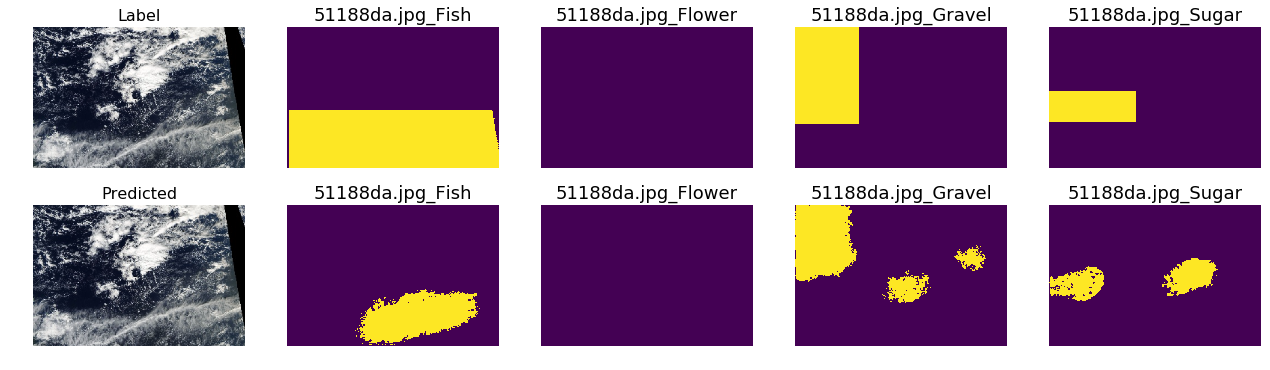

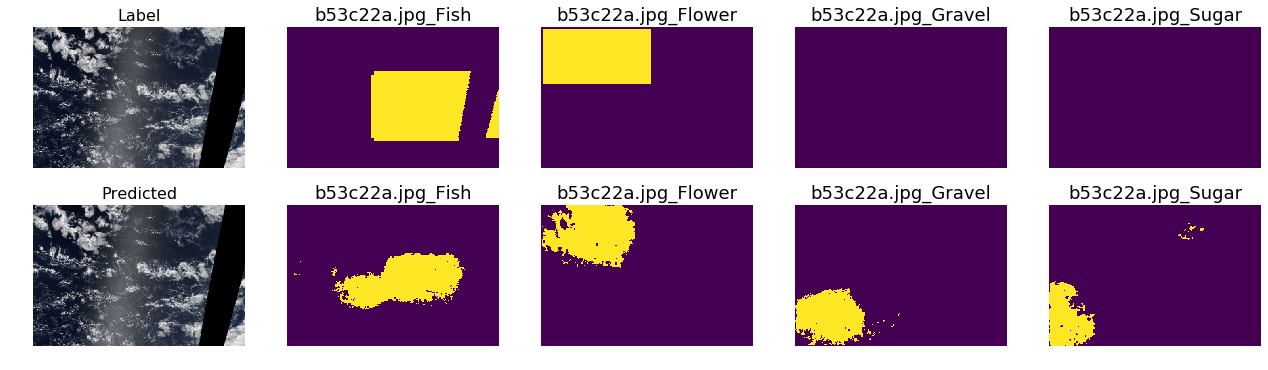

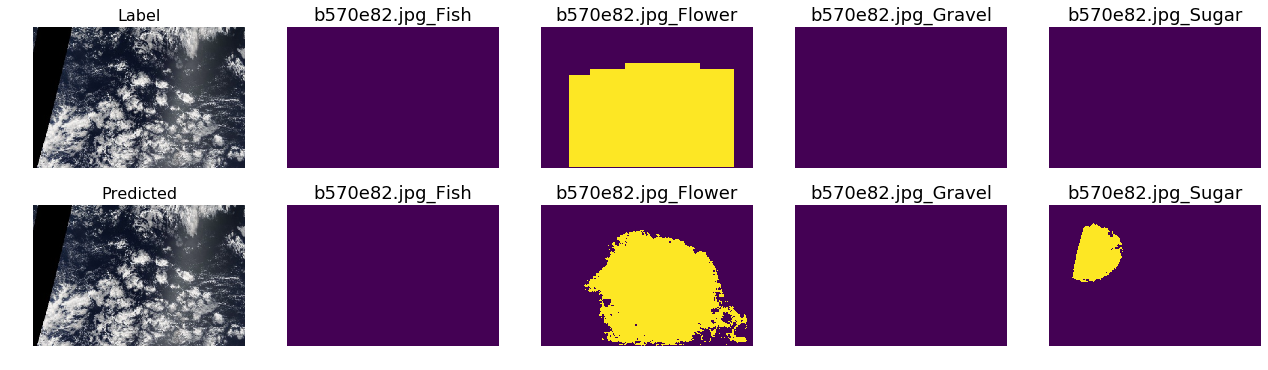

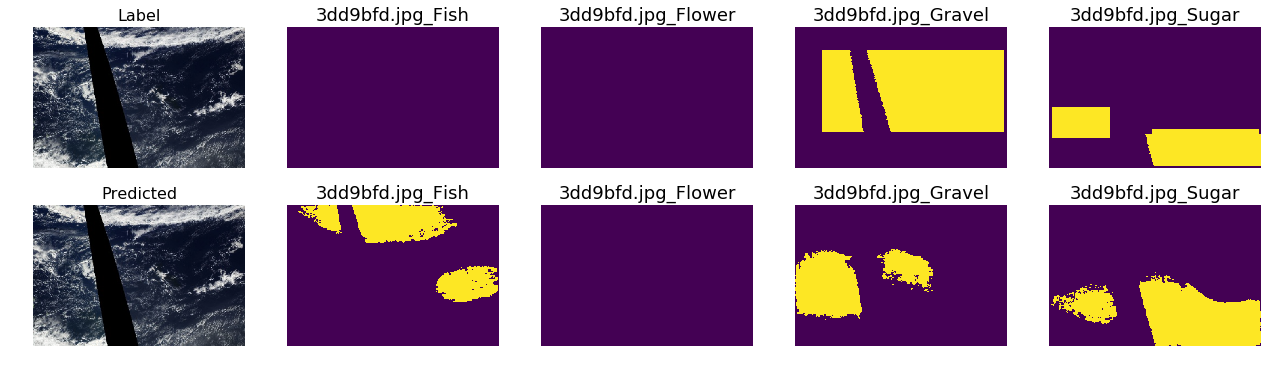

In [14]:
images_to_inspect = np.random.choice(X_val['image'].unique(), 4, replace=False)
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=len(inspect_set), 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
#                     preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = model.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].round().astype(int)
    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    inspect_set_temp.append(image_df)
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[...,class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds[class_index], min_size=best_masks[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    ###


inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process

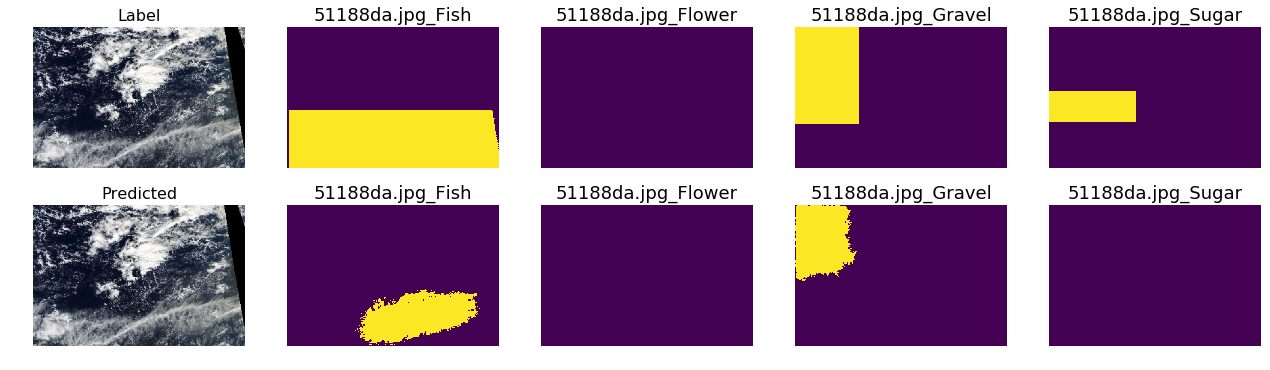

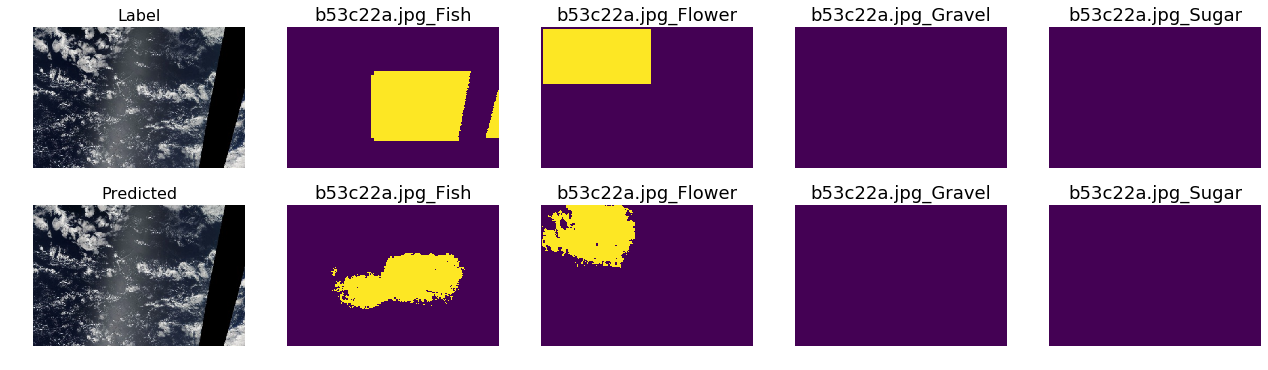

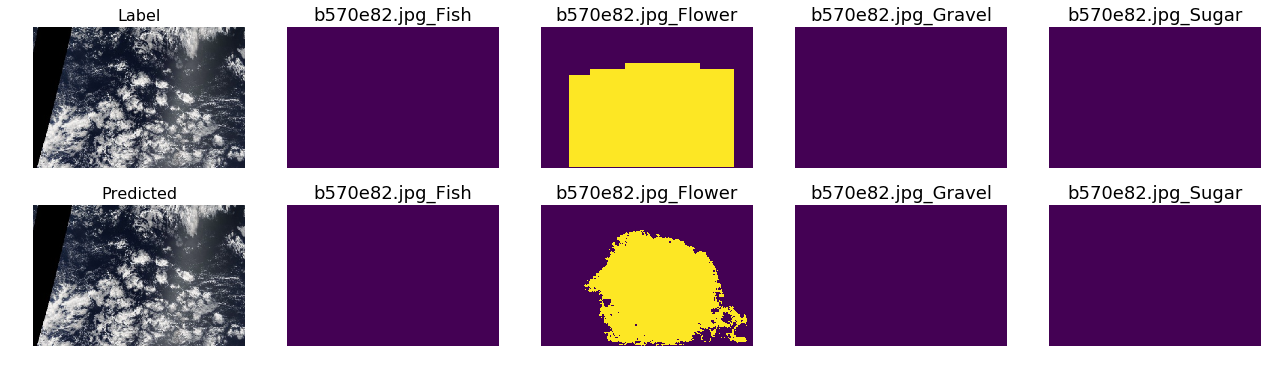

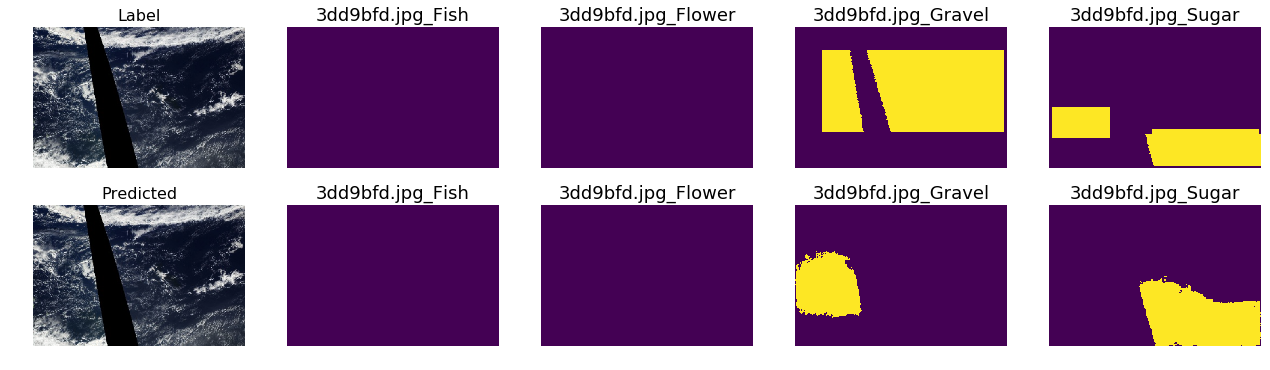

In [15]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')

## Inspecting some of the test set predictions

### Without post-process

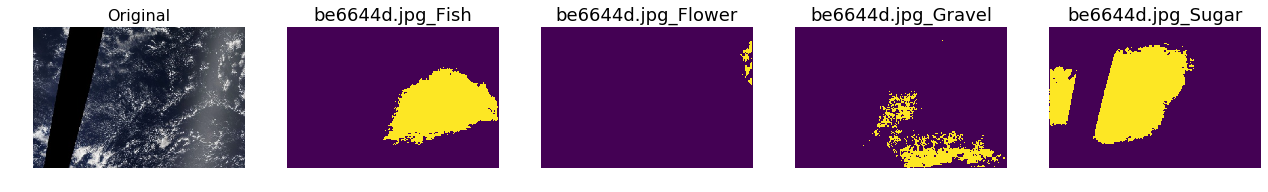

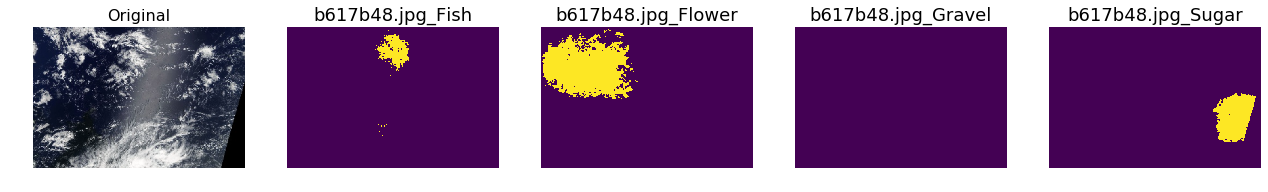

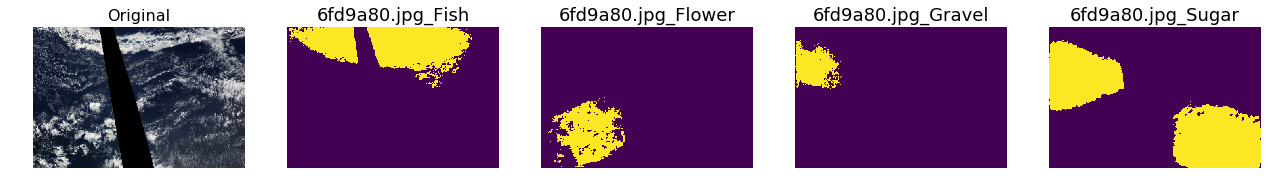

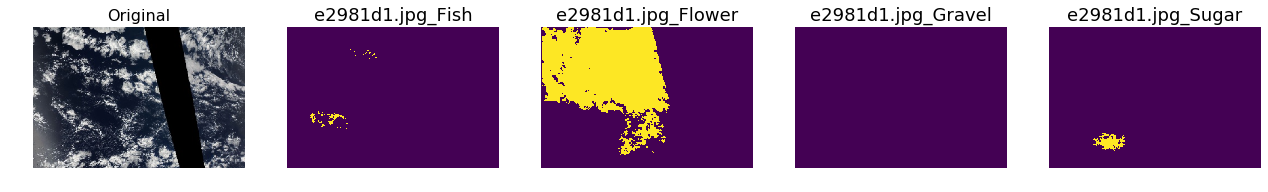

In [16]:
# Choose 5 samples at random
images_to_inspect_test =  np.random.choice(sub_df['image'].unique(), 4)
inspect_predictions(sub_df, images_to_inspect_test, test_images_path)

### With post-process

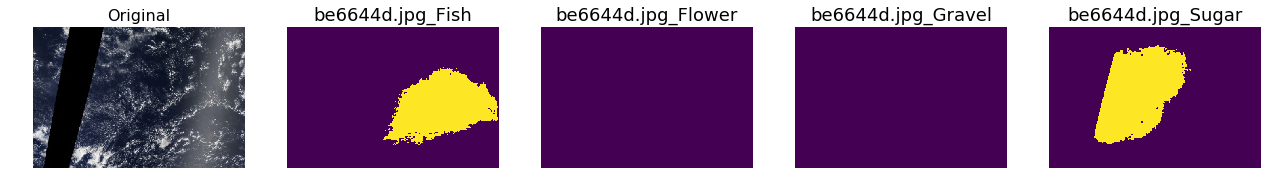

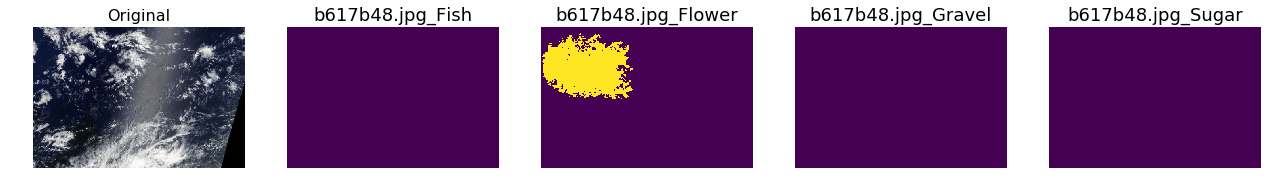

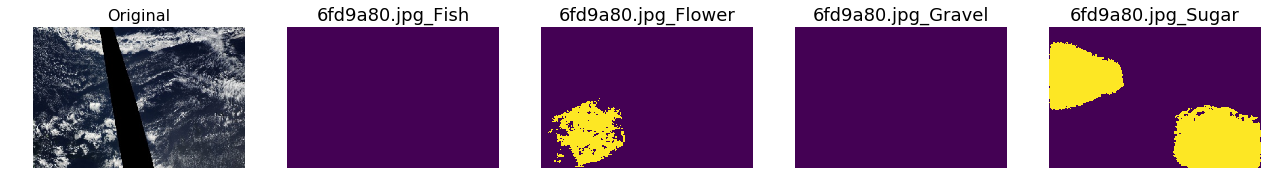

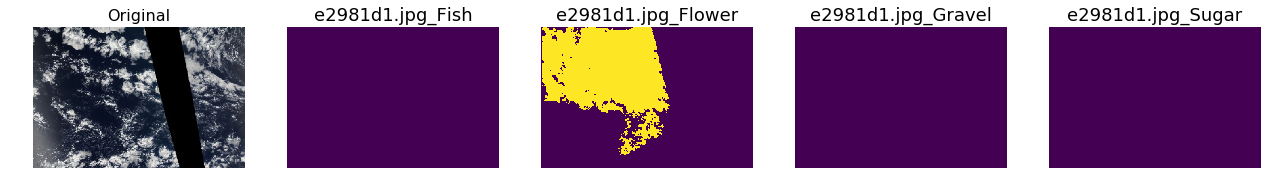

In [17]:
inspect_predictions(sub_df, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post')

### Regular submission

In [18]:
submission_df = sub_df[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,4 3 10 225 241 10 255 73 331 6 354 3 360 225 5...
3,002f507.jpg_Sugar,113194 1 113544 1 113890 1 113916 2 114240 1 1...
4,0035ae9.jpg_Fish,71135 3 71485 1 71835 1 72182 3 72517 2 72532 ...


### Submission with post processing

In [19]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,10 26 39 196 241 10 255 24 282 37 322 2 327 1 ...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,75354 3 75704 3 76054 4 76062 3 76076 1 76401 ...
